# Определение возраста покупателей по фотографии

## Описание  
Cупермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов для следующих целей:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.  
Выбрана метрика МАЕ, цель - менее 7.0.

## Цель проекта
Разработать модель для определения возраста покупателя по фотографии.

## План работы  
1. Загрузка данных и исследовательский анализ данных
2. Разработка модели
3. Анализ модели и формулирование выводов

## Загрузка данных и исследовательский анализ данных

In [1]:
# Импорты библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# Константы
RANDOM_STATE = 153
image_path = '/content/drive/MyDrive/DataScience/Datasets/images'
path = '/content/drive/MyDrive/DataScience/Datasets/'

In [3]:
# Подключаем google disk. Датасет залит на google disk, обучение проводится на cpu google colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Загрузка датасета с метками возраста
df = pd.read_csv(path + 'labels.csv')
df.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [5]:
# Проверим количество записей в датасете
df.shape

(7591, 2)

7591 меток возраста. Совпадает с количеством файлов.

In [6]:
# Проверим дубликаты
df.duplicated().sum()

0

Дубликатов нет.

In [7]:
# Посмотрим характеристики выборки. Построим гистограмму рапределения.
print(df.real_age.describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


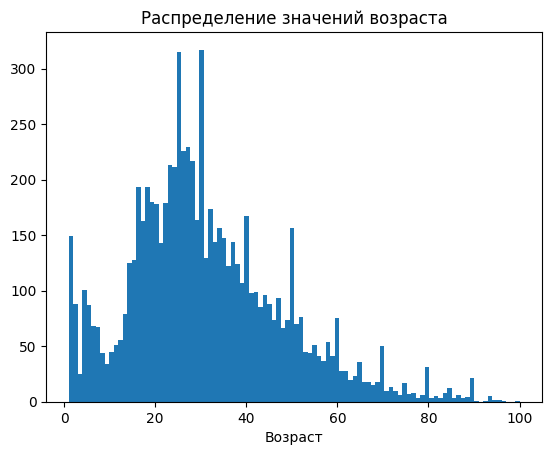

In [8]:
plt.hist(df.real_age, bins=100);
plt.title('Распределение значений возраста')
plt.xlabel('Возраст');

Имеем значения возраста от 0 до 100 лет.  
Преобладают наблюдения от 15 до 50 лет.

In [9]:
# Используем ImageDataGenerator для загрузки изображений и меток таргета.
datagen = ImageDataGenerator(rescale=1/255)
datagen_flow = datagen.flow_from_dataframe(dataframe=df,
                                           directory=image_path,
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(244, 244),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=12345)

Found 7591 validated image filenames.


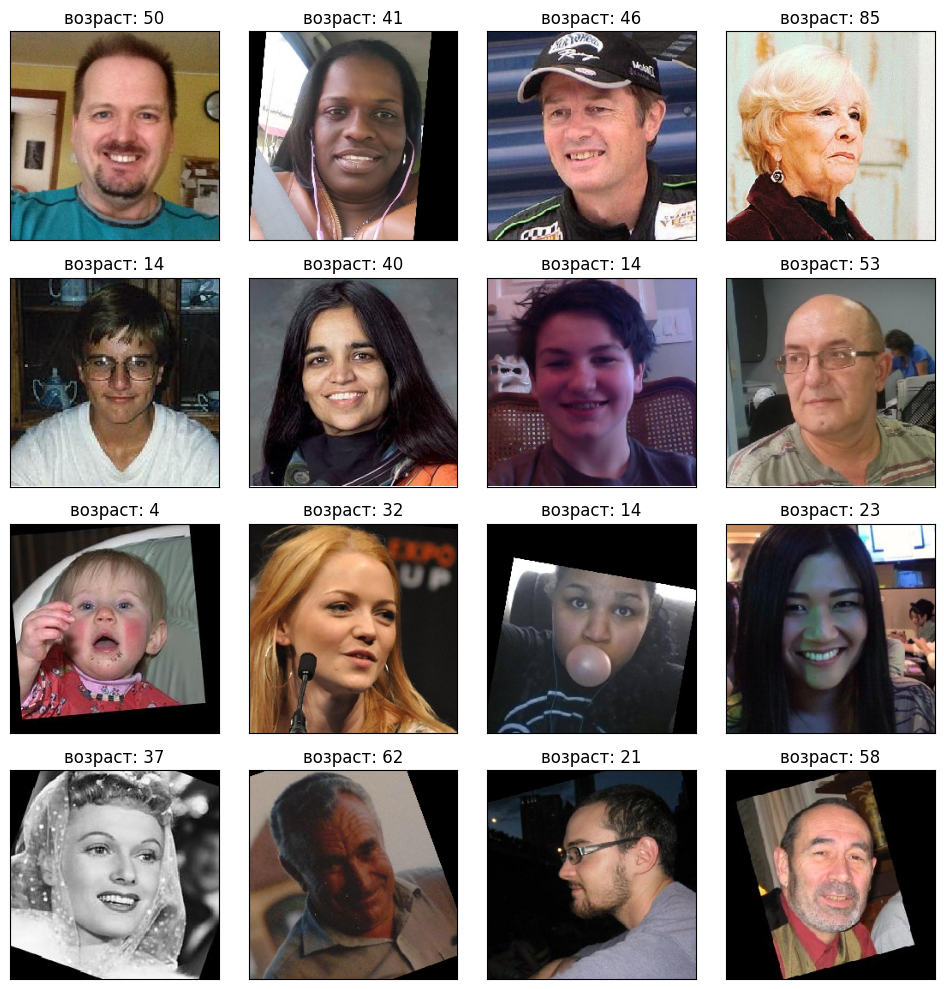

In [10]:
# посмотрим на изображения из датасета
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('возраст: ' + str(target[i]))

Выводы по исследовательскому анализу данных:
1. Имеем 7591 фотографий людей разного возраста
2. Фотографии разного качества, цветные и черно-белые, разной ориентации и с разных ракурсов
3. Возраст от 0 до 100 лет, преобладают примеры от 15 до 50 лет.
4. Дубликаты отсутствуют.

## Разработка модели

In [11]:
# Загрузка тренировочного и валидационного датасетов 75/25, применяем аугментацию
datagen_train = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.25,
                                    rotation_range=15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)
datagen_flow_train = datagen_train.flow_from_dataframe(dataframe=df,
                                                        directory=image_path,
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        class_mode='raw',
                                                        target_size=(244, 244),
                                                        batch_size=32,
                                                        subset='training',
                                                        seed=12345)

datagen_valid = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.25,
                                    rotation_range=15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)

datagen_flow_valid = datagen_valid.flow_from_dataframe(dataframe=df,
                                                    directory=image_path,
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    class_mode='raw',
                                                    target_size=(244, 244),
                                                    batch_size=32,
                                                    subset='validation',
                                                    seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [12]:
# Конфигурация нейросети
optimizer = Adam(learning_rate = 0.00003)
backbone = ResNet50(input_shape=(244, 244, 3),
                    weights='imagenet',
                    include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=optimizer,
                loss='mae',
                metrics=['mae'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
# Обучние модели
model.fit(datagen_flow_train,
          validation_data=datagen_flow_valid,
          batch_size=32,
          epochs=11,
          steps_per_epoch=237,
          validation_steps=None,
          verbose=2,
          shuffle=True)

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


237/237 - 2870s - 12s/step - loss: 14.2482 - mae: 14.2482 - val_loss: 27.4022 - val_mae: 27.4022
Epoch 2/11
237/237 - 159s - 670ms/step - loss: 7.9899 - mae: 7.9899 - val_loss: 26.1116 - val_mae: 26.1116
Epoch 3/11
237/237 - 154s - 649ms/step - loss: 7.2638 - mae: 7.2638 - val_loss: 16.7730 - val_mae: 16.7730
Epoch 4/11
237/237 - 202s - 850ms/step - loss: 6.6639 - mae: 6.6639 - val_loss: 10.5096 - val_mae: 10.5096
Epoch 5/11
237/237 - 201s - 849ms/step - loss: 6.1528 - mae: 6.1528 - val_loss: 7.2259 - val_mae: 7.2259
Epoch 6/11
237/237 - 202s - 851ms/step - loss: 6.0317 - mae: 6.0317 - val_loss: 7.3944 - val_mae: 7.3944
Epoch 7/11
237/237 - 153s - 644ms/step - loss: 5.6630 - mae: 5.6630 - val_loss: 6.3295 - val_mae: 6.3295
Epoch 8/11
237/237 - 153s - 646ms/step - loss: 5.3759 - mae: 5.3759 - val_loss: 6.7286 - val_mae: 6.7286
Epoch 9/11
237/237 - 153s - 646ms/step - loss: 5.2466 - mae: 5.2466 - val_loss: 6.9718 - val_mae: 6.9718
Epoch 10/11
237/237 - 154s - 648ms/step - loss: 5.1044 - 

Выводы по разработке модели.
1. Разработана модель на базе ResNet с предобученными весами imagenet.
2. Использована аугментация изображений (поворот, сдвиг по ширине и высоте, зум). Изображения приведены к разрешению 244х244.
3. Обучение проводилось с использование батча в 32 изображения, 11 эпох обучения.
4. Достигнуто значение mae 6.9 на валидационной выборке

### Анализ модели и формулирование выводов

In [14]:
# Параметры модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,663,045 (269.56 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,073,284 (179.57 MB)

## Выводы

1. Разработана нейросетевая модель для предсказания возраста по фотографии.  
2. За основу нейросети взята ResNet50, предобученная на imagenet, 23,5  млн. параметров.  
3. Модель дообучена на датасете с 5.6 тыс. фотогорафий покупателей. В обучающей выборке представлены фото людей от 0 до 100 лет (преобладают 15-50 лет), фото разного качества, цветные и черно-белые, разной ориентации и с разных ракурсов.  
4. Применена аугментация изображений (ротация, сдвиг по ширине и высоте, зум). Обучение проводилось на изображениях разрешением 244х244. Обучение батчами по 32, 11 эпох.
5. Достигнута точность предсказания на валидации 6.9 лет. Поставленная цель достигнута.  

Рекомендации заказчику:
1. Для повышения точности модели рекомендуется обучение на более релевантном датасете фотографий с камер прикассовой зоны.
2. Исходя из бизнес-задачи можено рекомендовать применить не регрессию, а классификацию на возрастные группы в соответствии с сегментированием покупателей по возрасту.